<h1>Session 15. Logit and Decision Tree using Affaires data</h1>

<p>This notebook provides an example code of predicting whether a person will have an affair. 
<br>
<b>Dependent variable</b> - Did a person have an affair? (1-yes, 0-no)

<br><br>
The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of our variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables
<li>Devide data into training and testing sets 
<li><b> Model 1. Logistic Regression from statsmodel and interpretation of marginal effects</b>
<li><b> Model 2. Logistic Regression scaled the data</b>
<li><b> Model 3. Decision tree with scaled data</b>
<li> Summarising results
<li> Predicting for new individual using constructed models
</ol>
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
data=pd.read_excel("Affairs.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 10 columns):
ID               601 non-null int64
affairs          601 non-null int64
gender           601 non-null object
age              601 non-null float64
yearsmarried     601 non-null float64
children         601 non-null object
religiousness    601 non-null int64
education        601 non-null int64
occupation       601 non-null int64
rating           601 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 47.0+ KB


In [4]:
data.describe()

,ID,affairs,age,yearsmarried,religiousness,education,occupation,rating
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,1059.722130,0.249584,32.487521,8.177696,3.116473,16.166389,4.194676,3.931780
std,914.904611,0.433133,9.288762,5.571303,1.167509,2.402555,1.819443,1.103179
min,4.000000,0.000000,17.500000,0.125000,1.000000,9.000000,1.000000,1.000000
25%,528.000000,0.000000,27.000000,4.000000,2.000000,14.000000,3.000000,3.000000
50%,1009.000000,0.000000,32.000000,7.000000,3.000000,16.000000,5.000000,4.000000
75%,1453.000000,0.000000,37.000000,15.000000,4.000000,18.000000,6.000000,5.000000
max,9029.000000,1.000000,57.000000,15.000000,5.000000,20.000000,7.000000,5.000000


In [5]:
data_object=data.select_dtypes(include="object")
data_numeric=data.select_dtypes(exclude="object")

In [6]:
for i in data_object.columns:
    print(data_object[i].unique())

['male' 'female']
['no' 'yes']


In [7]:
#another way of finding number of unique values of each object variable
print(data_object.nunique())

gender      2
children    2
dtype: int64


In [8]:
#let's check for 0 variance
data_numeric.var()==0

ID               False
affairs          False
age              False
yearsmarried     False
religiousness    False
education        False
occupation       False
rating           False
dtype: bool

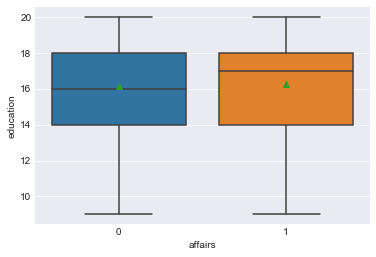

In [9]:
#let's see whether there is diiference in distribution of education by those who had and didn't have affairs
sns.set_style("darkgrid")
sns.boxplot(data.affairs,data.education,showmeans=True)
plt.show()

<b>We see that median value of years of education is slightly higher for those who had affair compared to those who didn't.</b>

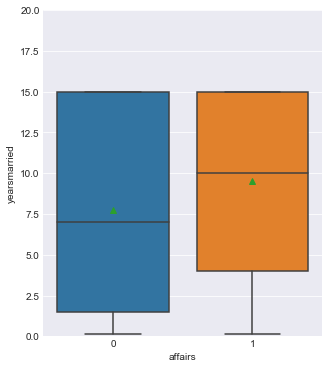

In [10]:
#let's see whether there is diiference in distribution of years married by those who had and didn't have affairs
plt.figure(figsize=(5,6))
sns.set_style("darkgrid")
sns.boxplot(data.affairs,data.yearsmarried,showmeans=True)
plt.ylim(0,20)
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


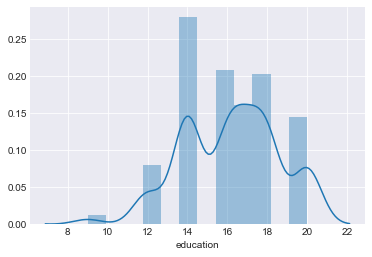

In [11]:
#plot the distribution using seaborn
sns.distplot(data.education)
plt.show()

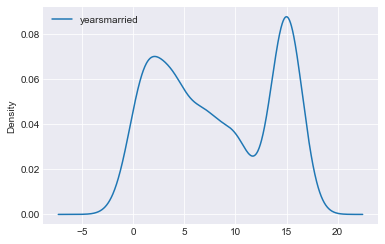

In [12]:
#plot the distribution without using seaborn
data.plot(y="yearsmarried",kind="density")

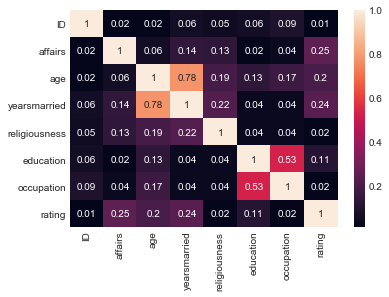

In [13]:
#let's check for correlation between variables
sns.heatmap(data_numeric.corr().abs().round(2),annot=True)
plt.show()

In [14]:
#let's drop ID because it doesn't give any valuable information
#let's drop age as it has higher correlation with yearsmarried
data_numeric.drop(["ID","age"],axis=1,inplace=True)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


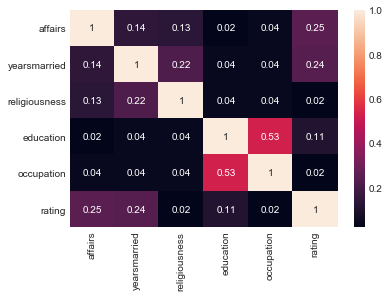

In [15]:
#no correlation anymore
sns.heatmap(data_numeric.corr().abs().round(2),annot=True)
plt.show()

In [16]:
#let's do train, test splitting, 75%-train data, 25%-test data
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)
data_final=data_dummies.join(data_numeric)
X=data_final.drop("affairs",axis=1)
Y=data_final.affairs
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [17]:
#we see that in numeric dataset there is a "affairs" variable which is not in X_train data
print(x_train.info())
print("-------------------------------")
print(data_numeric.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 531 to 102
Data columns (total 7 columns):
gender_male      450 non-null uint8
children_yes     450 non-null uint8
yearsmarried     450 non-null float64
religiousness    450 non-null int64
education        450 non-null int64
occupation       450 non-null int64
rating           450 non-null int64
dtypes: float64(1), int64(4), uint8(2)
memory usage: 22.0 KB
None
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 6 columns):
affairs          601 non-null int64
yearsmarried     601 non-null float64
religiousness    601 non-null int64
education        601 non-null int64
occupation       601 non-null int64
rating           601 non-null int64
dtypes: float64(1), int64(5)
memory usage: 28.2 KB
None


In [18]:
#let's scale data
scaler=StandardScaler()
scaler.fit(x_train[data_numeric.drop("affairs",axis=1).columns.tolist()]) #lets's take all numeric variables except affairs
x_train_scaled=pd.DataFrame(scaler.transform(x_train[data_numeric.drop("affairs",axis=1).columns.tolist()]),
             columns=data_numeric.drop("affairs",axis=1).columns.tolist()).join(data_dummies)
x_test_scaled=pd.DataFrame(scaler.transform(x_test[data_numeric.drop("affairs",axis=1).columns.tolist()]),
             columns=data_numeric.drop("affairs",axis=1).columns.tolist()).join(data_dummies)
x_test_scaled.head()

,yearsmarried,religiousness,education,occupation,rating,gender_male,children_yes
0,-0.212044,0.766288,0.342167,-1.744878,0.956682,1,0
1,0.323895,0.766288,-0.909664,-0.107918,0.956682,0,0
2,0.323895,0.766288,-0.909664,-1.744878,0.956682,0,1
3,-0.747983,-0.080959,0.342167,0.983389,0.956682,1,1
4,-1.194599,0.766288,-0.909664,0.983389,0.956682,1,0


# Model 1. Logistic Regression from statsmodel and interpretation of marginal effects

In [19]:
#let's get formula for logistic regression
formula="affairs~"+"+".join(X.columns)
print(formula)

affairs~gender_male+children_yes+yearsmarried+religiousness+education+occupation+rating


In [20]:
logit1=Logit.from_formula(formula=formula,data=data_final).fit()
logit1.summary()

Optimization terminated successfully.
         Current function value: 0.512203
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                affairs   No. Observations:                  601
Model:                          Logit   Df Residuals:                      593
Method:                           MLE   Df Model:                            7
Date:                Sat, 24 Nov 2018   Pseudo R-squ.:                 0.08841
Time:                        22:08:46   Log-Likelihood:                -307.83
converged:                       True   LL-Null:                       -337.69
                                        LLR p-value:                 1.725e-10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5305      0.806      0.658      0.511      -1.050       2.111
gender_male       0.1727      0.233      0.743      0.458      -0.283       0.629
children_yes      0.4229      0.290      1.460      0.144      -0.145       0.990
yearsmarried      0.0379      0.022      1.703      0.089      -0.006       0.081
religiousness    -0.3278      0.089     -3.683      0.000      -0.502      -0.153
education         0.0165      0.050      0.332      0.740      -0.081       0.114
occupation        0.0194      0.071      0.273      0.785      -0.120       0.159
rating           -0.4546      0.090     -5.070      0.000      -0.630      -0.279
=================================================================================
"""

<b>Interpreting for continuous variable</b>
If p<=0.05,then there is a statistically significant relationship between affairs and corresponding variable. So, incraese in religiousness will decrease the likelihood(probability) of having affairs. And, increase in rating will decrease the probability of affairs.

In [21]:
#we should calculate marginal effects to be able to interpret change of y variable
logit1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                affairs
Method:                          dydx
At:                           overall
=================================================================================
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male       0.0291      0.039      0.743      0.457      -0.048       0.106
children_yes      0.0712      0.049      1.466      0.143      -0.024       0.166
yearsmarried      0.0064      0.004      1.715      0.086      -0.001       0.014
religiousness    -0.0552      0.014     -3.812      0.000      -0.084      -0.027
education         0.0028      0.008      0.332      0.740      -0.014       0.019
occupation        0.0033      0.012      0.273      0.785      -0.020       0.027
rating           -0.0766      0.014     -5.460      0.000      -0.104      -0.049
=================================================================================
"""

<b>As p-value of religiousness is less than 0.05, we will interpret the marginal effects of this variable. An incrimental increase in religiousness will decrease the probability of having affairs on average by 5% (0.0552*100%) if other factors hold constant.</b>

# Model 2. Logistic Regression with scaled data from sklearn

In [22]:
#to concatenate back scaled train and test sets, to be able to run GridSearchCV on whole data
X_scaled=pd.concat([x_train_scaled,x_test_scaled])
Y_final=pd.concat([y_train,y_test])

In [23]:
#with not scaled data
gridsearch1=GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),param_grid={"penalty":["l1","l2"],"C":np.linspace(0.0001,50,20)},
                        scoring="roc_auc",
                        cv=5,n_jobs=-1).fit(X_scaled,Y_final)

In [24]:
best=list(gridsearch1.best_params_.values())
print(best)

[0.0001, 'l2']


In [25]:
logit_scaled=LogisticRegression(C=best[0],penalty=best[1],
                                    class_weight="balanced",random_state=42).fit(x_train_scaled,y_train)

# Model 3. Decision Tree with  scaled Data

In [26]:
gridsearch2=GridSearchCV(DecisionTreeClassifier(class_weight="balanced",random_state=42),param_grid={"max_depth":(5,15),"min_samples_leaf":(50,150,25)},
                        scoring="roc_auc",
                        cv=5,n_jobs=-1).fit(x_train_scaled,y_train)
best2=list(gridsearch2.best_params_.values())
print(best2)
tree_scaled=DecisionTreeClassifier(class_weight="balanced",random_state=42, max_depth=best2[0],
                             min_samples_leaf=best2[1]).fit(X_scaled,Y_final)

[5, 50]


<h1>Summarising results</h1>

<h3> Confusion matrix </h3>

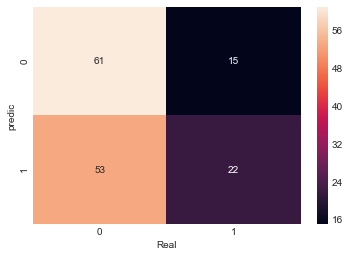

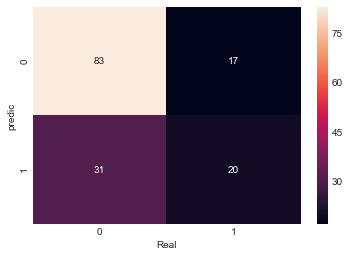

In [27]:
#let's print confusion matrix for logit and decision tree
for i in [logit_scaled,tree_scaled]:
    sns.heatmap(confusion_matrix(y_test,i.predict(x_test_scaled)).T,annot=True)
    plt.xlabel("Real")
    plt.ylabel("predic")
    plt.show()

<h3>Recall, Roc_AUC, Accuracy</h3>

In [28]:
for i in [logit_scaled,tree_scaled]:
    print("roc_auc=",roc_auc_score(y_test,i.predict(x_test_scaled)))
for i in [logit_scaled,tree_scaled]:
    print("recall=",recall_score(y_test,i.predict(x_test_scaled)))
for i in [logit_scaled,tree_scaled]:
    print("accuracy train=",i.score(x_train_scaled,y_train)) 
for i in [logit_scaled,tree_scaled]:
    print("accuracy test=",i.score(x_test_scaled,y_test))

roc_auc= 0.5648411569464202
roc_auc= 0.6343053579895686
recall= 0.5945945945945946
recall= 0.5405405405405406
accuracy train= 0.6533333333333333
accuracy train= 0.7333333333333333
accuracy test= 0.5496688741721855
accuracy test= 0.6821192052980133


<h1>Predicting for new individual</h1>

In [29]:
X_new_num=[[10,4,14,4,3]] #as we scaled only numeric data, we shoud transfrom only numeric variables for new individual
X_new_dum=[[1,0]] #values for dummy variables
X_new_num=scaler.transform(X_new_num) #let's apply scaler to new data
X_new_scaled=np.append(X_new_num,X_new_dum) #let's join scaled numeric variables to dummy variables
X_new_scaled

array([ 0.32389486,  0.76628813, -0.90966441, -0.10791812, -0.86749945,
        1.        ,  0.        ])

In [30]:
print("logit:",logit_scaled.predict(X_new_scaled.reshape(1,-1))) #as we have data only for 1 individual, reshape() is necessary 
print("DT:",tree_scaled.predict(X_new_scaled.reshape(1,-1)))

logit: [1]
DT: [0]
